# 製品プライサーは継続しました

その説明から、何かがどれだけの費用がかかるかを推定できるモデル。

## ベースラインモデル

今日、私たちは最も単純なモデルに取り組み、打ち負かす出発点として機能します。

In [1]:
# import

import os
import random
import math
import json
import pickle

from dotenv import load_dotenv
from huggingface_hub import login

import numpy as np
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [2]:
# 従来のMLのためのより多くのimport

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLPインポート

次のセルでは、NLP関連のMLのためのimportが増えています。  
Gensimのインポートが 'scipy.linalg' から 'triu' をインポートできないようなエラーを提供する場合は、別のセルで実行してください。  
`!pip install "scipy<1.13"`  

StackoverFlow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens)で説明されているとおり。

これを並べ替えてくれたArnaldo GとArd Vに感謝します。

In [3]:
#!pip install -U gensim
#!pip install -U numpy
!pip install numpy==1.26.4 # https://ml-rand-note.hatenablog.com/entry/error-numpy-size-changed
!pip install "scipy<1.13"
!pip install gensim

In [4]:
# NLP関連のimport

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [5]:
# 最後に、より高度なMLのためのより多くのimport

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [6]:
# 定数 - 出力の色に使用されます

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [7]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
#os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [8]:
# Hugging Faceにログイン

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [9]:
# もう1つのインポート - Item クラスに加え ItemLoader
# loaders.pyの処理内容は、ファイル内にコメントを追加したので必要に応じて参照可。
from items import Item
#from loaders import ItemLoader

In [10]:
# JupiterNotebookでmatplotlibを表示できるようにする。
%matplotlib inline

# PKLファイルのロード

すべてのデータを再度キュレーションすることを避けましょう！pickleファイルをロード

2日目にまだこれらを作成していない場合は、Googleドライブからダウンロードすることもできます（ここにスライドもあります）：  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

しかし、ファイルは非常に大きいことに注意してください - コーヒーを手に入れる必要があるかもしれません！

In [11]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

以下は、lite版を使用する場合

```python
with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)
with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)
```

In [12]:
# トレーニングプロンプト
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [13]:
# テストプロンプト
print(test[0].prompt)

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $374.00


## たくさん使用する強力なスクリプトを発表します！

テストセットから250アイテムに対してモデルを評価するかなり心地よいテストハーネス

そして、結果を視覚的に満足のいく方法で見せてください。

このフォームの関数を書きます。

```python
def my_prediction_function(item):
    # my code here
    return my_estimate
```

そして、呼び出します：

`Tester.test(my_prediction_function)`

モデルを評価します。

In [14]:
# MLやpredictorの予測精度を評価・可視化するためのユーティリティクラス Tester の実装
# 主に予測値（guess）と真値（truth）の比較や、エラー分析、簡単な結果の可視化・集計を行う
class Tester:
    
    #Testerインスタンスの初期化
    def __init__(self, predictor, title=None, data=test, size=250):

        # 引数退避
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        
        # 内部状態
        self.guesses = [] # 予測値
        self.truths = []  # 正解値
        self.errors = []  # 絶対誤差
        self.sles = []    # 二乗対数誤差
        self.colors = []  # 評価色

    # 誤差の大きさに応じて、結果の色を決定。
    # 誤差40$未満 or 誤差/真値 < 0.2 → "green"
    # 誤差80$未満 or 誤差/真値 < 0.4 → "orange"
    # それ以外 → "red"
    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    # 指定番号のデータで予測を行い、評価・記録・表示
    def run_datapoint(self, i):
        datapoint = self.data[i]
        # 予測値
        guess = self.predictor(datapoint)
        # 正解値
        truth = datapoint.price
        # 絶対誤差
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        # 二乗対数誤差
        sle = log_error ** 2
        # 評価色
        color = self.color_for(error, truth)

        # 件名が長ければ省略表示
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."

        # 結果を格納
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)

        # 色付きprintで出力
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    # 真値（truth）と予測値（guess）の散布図をプロット
    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    # 検証全体の統計指標（平均誤差、RMSLE, "green"ヒット率）を集計し、チャートを表示
    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    # 指定件数すべてのデータで検証 (run_datapoint) を実行 → reportで集計＆可視化
    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    # @classmethodとして、与えた関数を使って即座にテストを走らせるユーティリティ
    # @classmethod：クラス自体を第1引数で受け取りインスタンスを作らなくても使える関数
    @classmethod
    def test(cls, function):
        cls(function).run()

# 今、基本的な何かのために

想像できる最もシンプルなモデルは何ですか？

乱数ジェネレーターから始めましょう！

## ランダム予測モデルの場合

In [15]:
# itemをガン無視して、ランダムな値を返す（1-999$）

# ランダムシードを設定します
random.seed(42)

def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

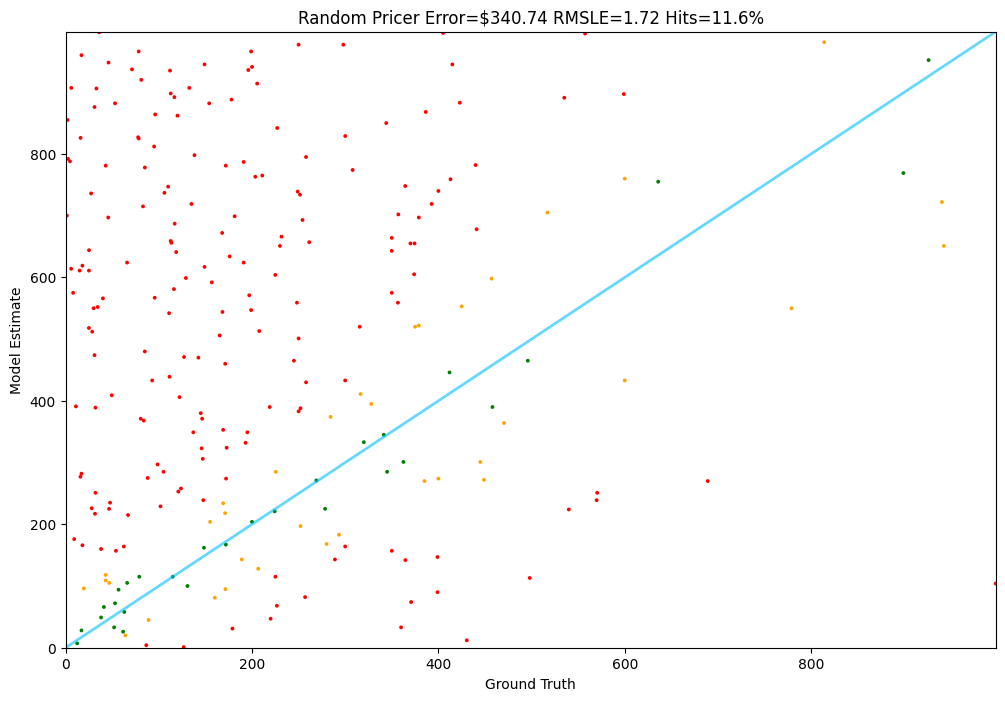

In [16]:
# TestRunnerを実行
Tester.test(random_pricer)

## 平均値予測モデルの場合

In [17]:
# itemをガン無視して、計算済みの平均値を返す

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $220.46 Truth: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $220.46 Truth: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $220.46 Truth: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $65.99 Error: $154.47 S

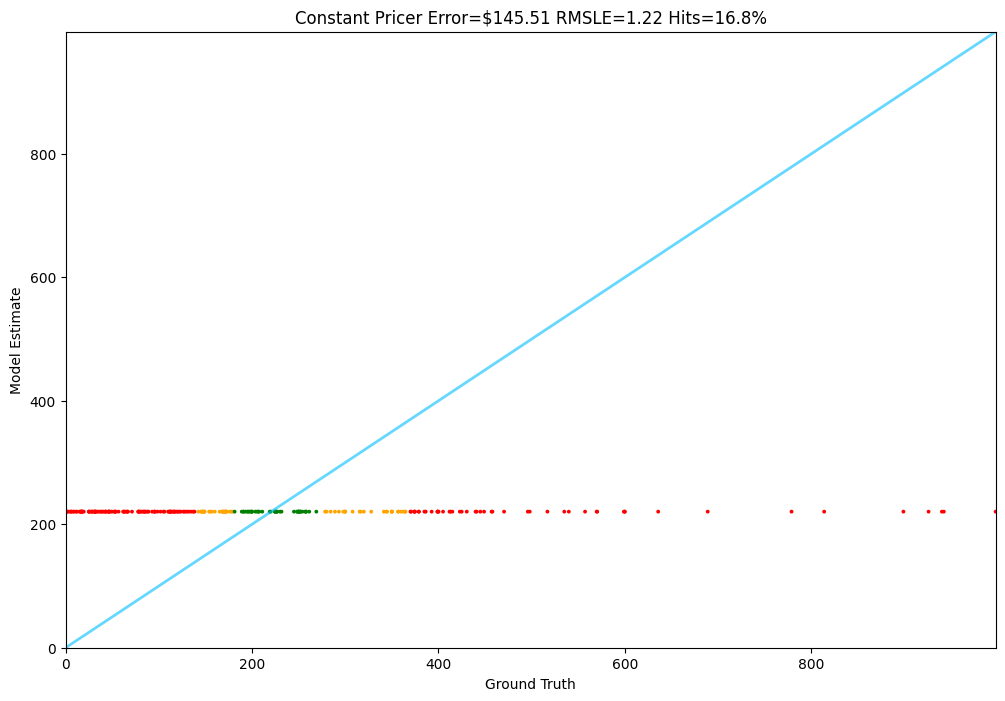

In [18]:
# TestRunnerを実行（コッチのほうが損失は低くなる）
Tester.test(constant_pricer)

## 特徴量エンジニアリング＋線形回帰予測モデルの場合

### 特徴量エンジニアリング
MLMを適用するため、新たな特徴量を作成する。

In [19]:
# details（dict）フィールド
train[0].details

'{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": "Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be shipped within U.S.", "International Shipping": "This item is not eligible for international shipping.  Learn More", "Date First Available": "August 9, 2006"}'

In [20]:
# 新しい features フィールドにJSON化した details (dict) を入力

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# 1つを見てください

In [21]:
# JSONのdictのキー
train[0].features.keys()

dict_keys(['Brand', 'Fit Type', 'Item Dimensions LxWxH', 'Item Weight', 'Auto Part Position', 'Operation Mode', 'Manufacturer', 'Model', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'OEM Part Number', 'Best Sellers Rank', 'Domestic Shipping', 'International Shipping', 'Date First Available'])

In [22]:
# trainの機能属性の上位20件

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

#### Item Weight

In [23]:
# itemの重さを取得しポンド単位に標準化する関数
# 単位が分からない時は、printし、return None。
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [24]:
# 全 train の weight をリスト化
weights = [get_weight(t) for t in train]
# 欠損（None）を除外
weights = [w for w in weights if w]

In [25]:
# 平均値計算
average_weight = sum(weights)/len(weights)
average_weight

13.570552370295237

In [26]:
# item の weight を取得、できない場合は平均値
def get_weight_with_default(重さが取得できない場合は平均値を使う):
    weight = get_weight(item)
    return weight or average_weight

#### Best Sellers Rank
商品カテゴリ中で何番目に売れているか？を表す値。

In [27]:
# Best Sellers Rank (dict) の平均値を返す
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [28]:
# 全 train の rank をリスト化
ranks = [get_rank(t) for t in train]
# 欠損（None）を除外
ranks = [r for r in ranks if r]

In [29]:
# 平均値計算
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828072

In [30]:
# item の rank を取得、できない場合は平均値
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

#### Text length

In [31]:
# item の text_length を取得
def get_text_length(item):
    return len(item.test_prompt())

#### Brand

In [32]:
# ブランドを調査

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# 上位40件
brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [33]:
# item の is_top_electronics_brand を取得
# TOP_ELECTRONICS_BRANDSに該当する場合はTrue（そうでなければFalse）
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

#### 特徴量エンジニアリングの結果

In [34]:
# 注：is_top_electronics_brandは（1/0）
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [35]:
# trainの特徴量エンジニアリングの結果
get_features(train[0])

{'weight': 0.2875,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

In [36]:
# itemsの特徴量をpd.DataFrameに変換

# ユーティリティ
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

# 実際の変換
train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

### 線形回帰予測モデル

In [37]:
# 従来の線形回帰！

np.random.seed(42)

# 個別の機能とターゲット
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# 線形回帰を訓練します
model = LinearRegression()
model.fit(X_train, y_train)

print("----- 係数 -----")
for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# テストセットを予測して評価します
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("----- 結果 -----")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

----- 係数 -----
weight: 0.0
rank: 5.3841193617461204e-05
text_length: 0.00643599997763539
is_top_electronics_brand: 196.94924001600964
Intercept: 186.01475400946978
----- 結果 -----
Mean Squared Error: 33919.35899591598
R-squared Score: 0.06656045384490539


### 学習済みモデルの評価

In [38]:
# itemの特徴量でMLM（線形回帰）が推定した値を返す

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $227.69 Truth: $374.41 Error: $146.72 SLE: 0.25 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $217.09 Truth: $225.11 Error: $8.02 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $194.29 Truth: $61.68 Error: $132.61 SLE: 1.29 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $390.33 Truth: $599.99 Error: $209.66 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $211.41 Truth: $16.99 Error: $194.42 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $211.47 Truth: $31.99 Error: $179.48 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $193.13 Truth: $101.79 Error: $91.34 SLE: 0.40 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $190.30 Truth: $289.00 Error: $98.70 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $211.12 Truth: $635.86 Error: $424.74 SLE: 1.21 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $199.61 Truth: $65.99 Error: $133.62 SL

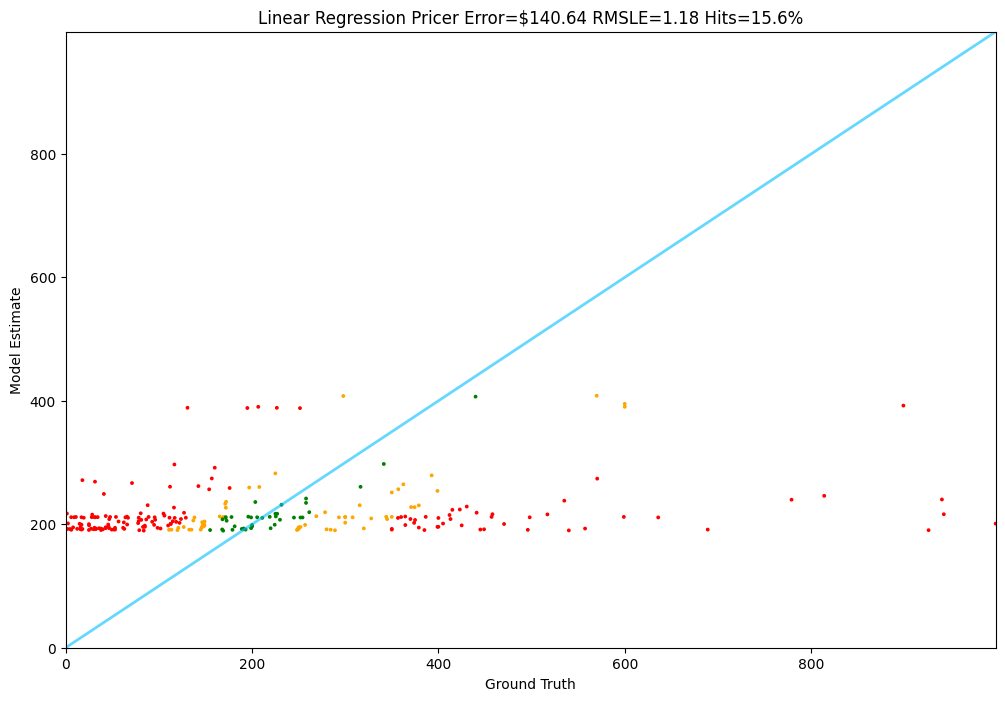

In [39]:
# TestRunnerを実行（さらに損失は低くなる）
Tester.test(linear_regression_pricer)

## 出現頻度ベクトル＋線形回帰予測モデルの場合

### 出現頻度ベクトル

In [40]:
# 文書と価格を準備 テストプロンプトを使用していることに注意

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

### 線形回帰予測モデル

In [41]:
# X：test_promptの出現頻度ベクトル、Y：price

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 学習済みモデルの評価

In [42]:
# itemのtest_promptの出現頻度ベクトルからMLM（線形回帰）が推定した値を返す
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.58 Truth: $374.41 Error: $77.83 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.14 Truth: $599.99 Error: $273.85 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.82 Truth: $101.79 Error: $243.03 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.56 Truth: $635.86 Error: $231.30 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.12 Truth: $65.99 Error: $45.13 SLE: 0

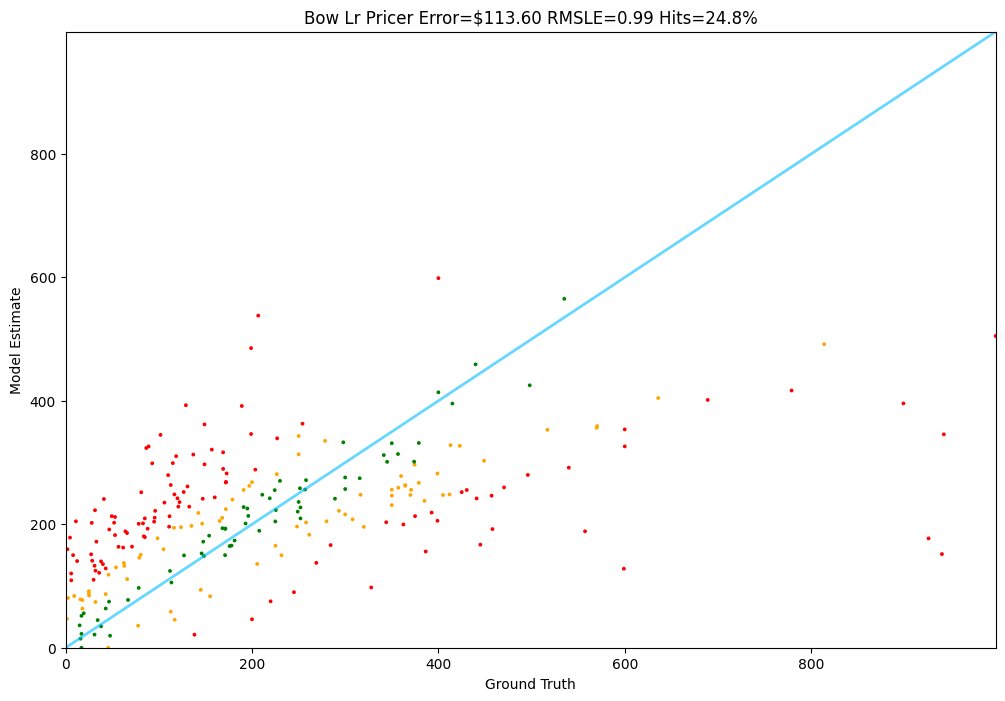

In [43]:
# TestRunnerを実行（さらに損失は低くなる）
Tester.test(bow_lr_pricer)

## 埋込ベクトル＋高度な予測モデルの場合

### 埋込ベクトル
残念ながら、ココでカーネルが死亡

In [44]:
# Gensim NLPライブラリに実装されている驚くべきWord2Vecモデル

np.random.seed(42)

# documents を gensim 付属の simple_preprocess で前処理
# documents = [item.test_prompt() for item in train]
processed_docs = [simple_preprocess(doc) for doc in documents]

# 前処理済みの文書でWord2Vecモデルをトレーニング
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [ ]:
# ドキュメント全体でベクトルを平均化するこのステップは、私たちのアプローチの弱点
# 単純平均：モデルが知らない単語は無視。何もベクトルがなければ、ゼロベクトルで返す。
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# 全文書をベクトル化し、(文書数 × 400) の特徴行列を作成
X_w2v = np.array([document_vector(doc) for doc in documents])

### 線形回帰

In [ ]:
# word2vecで線形回帰

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

In [ ]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

In [ ]:
Tester.test(word2vec_lr_pricer)

### 線形サポートベクター回帰

In [ ]:
# word2vecで線形サポートベクター回帰

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

In [ ]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

In [ ]:
Tester.test(svr_pricer)

### ランダムフォレスト回帰

In [ ]:
# word2vecでランダムフォレスト回帰

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)